# This notebook contains the code for reproducing results for the following aims:


*   Aim 1: Psychopathology outcome random forest models and analysis



# Install

In [4]:
# !pip install shap
# !pip install lime
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=e86cfa6eea5d54a70838080f271f50121717f9c122e025b7575a58305c4b216a
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


# Import Libraries



Import some libraries

In [5]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import io

# Utilities

Thesea are mostly helper functions to do miscellaneous data wrangling more easily. Run this whole block, since some of the functions are used later

In [6]:
# missing values per column function
def show_missing_values(df):
    missing_counts = df.isnull().sum()
    missing_percentages = 100 * missing_counts / len(df)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Values', ascending=False)
    return missing_table

In [7]:
def find_no_missing_cols(df):
    no_missing_cols = df.columns[df.isnull().sum() == 0]
    return no_missing_cols

In [8]:
def get_string_columns(df):
    string_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: any([i.isalpha() for i in str(x)])).any():
            string_cols.append(col)
    return string_cols

In [9]:
def convert_sex_to_binary(df, column_name):
    # create a new column with binary values
    df['binary_sex'] = df[column_name].apply(lambda x: 1 if x == 'M' else 0)
    return df

def convert_binary_to_sex(df, column_name):
    # create a new column with 'M' or 'F' values
    df['sex_from_binary'] = df[column_name].apply(lambda x: 'M' if x == 1 else 'F')
    return df

In [10]:
# get rid of nan and all that undefined behavior
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=False)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(float)

In [11]:
def select_all_except_first_row(df):
    return df.iloc[1:]

In [12]:
# missing values per row
def count_nan_rows(df):
    total_rows = len(df)
    nan_rows = df.isnull().any(axis=1).sum()
    nan_percent = 100 * (nan_rows / total_rows)
    print("Number of rows with NaN values: {}".format(nan_rows))
    print("Percentage of rows with NaN values: {:.2f}%".format(nan_percent))
    return nan_rows, nan_percent

In [13]:
def show_missing_rows(df):
    missing_counts = df.isnull().sum(axis=1)
    missing_percentages = 100 * missing_counts / len(df.columns)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Columns'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Columns', ascending=False)
    return missing_table

In [14]:
def count_value(df, value):
    count = (df == value).sum()
    count_table = pd.DataFrame({'Column': count.index, 'Count': count.values}).sort_values('Count', ascending=False)
    return count_table

In [15]:
def remove_rows_with_value(df, value):
    new_df = df[~(df == value).any(axis=1)]
    return new_df

In [16]:
def get_value_counts(df):
  # get unique values and counts for each column
  for column in df.columns:
      counts = df[column].value_counts()
      print(f"Counts for column '{column}':\n{counts}\n")

In [17]:
def compute_stats_ed(df, col1, col2, col3):
    df['Avg Ed'] = df.apply(lambda x: (x[col1] + x[col2])/2 if x[col3] == 1 else x[col1], axis=1)
    df['Max Ed'] = df.apply(lambda x: max(x[col1], x[col2]) if x[col3] == 1 else x[col1], axis=1)
    df['Sum Ed'] = df.apply(lambda x: x[col1] if x[col3] != 1 else x[col1] + x[col2], axis=1)
    return df

In [18]:
def check_number_in_columns(df, columns, number):
    for col in columns:
        if number in df[col].values:
            return True
    return False

In [19]:
def sum_columns(df, column_list, new_column_name):
    df[new_column_name] = df[column_list].sum(axis=1)
    return df

In [20]:
def distplots(df, bins=100):
  for i in range(1,len(df.columns)) :
      col_name = df.columns[i]  # get the column name to identify the graph
      x=df[col_name]
      plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
      k=plt.hist(x,bins)       # Change the right number of bins to get it more/less granular
      plt.show()

In [21]:
def select_columns(df, condition_col, condition_func, cols_to_select):
    """
    Selects a list of columns from a Pandas dataframe based on whether a condition is satisfied in one of the columns.
    """
    # Filter the dataframe to only include rows where the condition is satisfied
    filtered_df = df[df[condition_col].apply(condition_func)]

    # Select the desired columns from the filtered dataframe
    selected_df = filtered_df[cols_to_select]

    return selected_df

In [22]:
def check_value(df, value_cols, no_value_cols, value, new_col_name):
    # Check if value is present only in the specified value_cols
    mask_value = (df[value_cols] == value).all(axis=1)

    # Check if value is not present in any of the specified no_value_cols
    mask_no_value = (df[no_value_cols] != value).all(axis=1)

    # Create a new column with a 1 if both conditions are met, 0 otherwise
    df[new_col_name] = 0
    df.loc[mask_value & mask_no_value, new_col_name] = 1

    return df

In [23]:
def convert_str_to_num(df):
    """
    Converts string representations of numbers in a dataframe to float data type.
    """
    for col in df.columns:
        if df[col].dtypes == object:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # if the column can't be converted, ignore it
    return df

In [24]:
def convert_columns_to_float(df):
    """
    Converts all columns of a Pandas dataframe to be of type float, except for ones that contain alphabetic characters.
    """
    # Get a boolean mask indicating which columns contain alphabetic characters
    non_numeric_cols = df.select_dtypes(include=['object']).apply(lambda col: pd.to_numeric(col, errors='coerce').isna()).any()

    # Select only the numeric columns
    numeric_cols = df.select_dtypes(include=['float', 'int'])

    # Convert the numeric columns to float
    numeric_cols = numeric_cols.apply(pd.to_numeric, errors='coerce').astype('float')

    # Merge the numeric and non-numeric columns
    converted_df = pd.concat([numeric_cols, df.loc[:, non_numeric_cols]], axis=1)

    return converted_df

In [25]:
def column_description_dict(df):
    # Get the first row of the dataframe
    first_row = df.iloc[0]

    # Create a dictionary with column names as keys and first row values as descriptions
    column_descriptions = {col: first_row[col] for col in df.columns}

    return column_descriptions

In [26]:
def my_recode(x):
    if x == 1:
        return 1
    else:
        return 0

# Load dataframe

Raw csv from github is downloaded into a pandas dataframe

In [27]:
# Downloading the csv file from GitHub
url = "https://raw.githubusercontent.com/joshbenjamin3/251/main/Psychopathology%20outcomes.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

In [28]:
aims_df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [29]:
aims_df = aims_df.drop('Unnamed: 0', axis=1)

In [30]:
aims_df

,subjectkey,INR Group,INR,Highest Education Level,Household Size,Partner Status,Max Ed,Employment Category,Relationship Status,ADI,...,totprob_cat,internal_cat,external_cat,totprob_num,totprob_binary,internal_num,internal_binary,external_num,external_binary,Parent psychopathology
0,NDAR_INV01NAYMZH,mid income,2.584425,College,12.0,1,18.0,Not working,Partnered,27.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
1,NDAR_INV028WCTG6,deep poverty,0.122429,High school,3.0,0,14.0,Not working,Single,51.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
2,NDAR_INV00BD7VDC,high income,8.130081,Advanced degree,4.0,1,20.0,Part-time,Partnered,45.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
3,NDAR_INV02H7G2T6,high income,6.097561,Advanced degree,4.0,1,19.0,Part-time,Partnered,24.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
4,NDAR_INV030X9ZNH,mid income,3.040306,Advanced degree,5.0,1,19.0,Full-time,Partnered,48.0,...,Non-clinical,At risk,Non-clinical,0.0,0.0,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279,NDAR_INVYYA36DVL,poverty,0.934066,High school,9.0,1,13.0,Not working,Partnered,30.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
8280,NDAR_INVZ8JVVCW2,mid income,3.060725,Advanced degree,3.0,0,19.0,Part-time,Single,24.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
8281,NDAR_INVZJFZNNPJ,near poverty,1.727642,Some college,4.0,0,16.0,Full-time,Single,100.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0
8282,NDAR_INVZJJMNJ88,deep poverty,0.386179,Some college,4.0,1,15.0,Part-time,Partnered,98.0,...,Non-clinical,Non-clinical,Non-clinical,0.0,0.0,0.0,0.0,0.0,0.0,0


# Model ready dataframe

DataFrame is convereted to numpy array format for being input into models

## Aim 1

In [31]:
X_2 = aims_df[['Abuse', 'Race grouping', 'Sex', 'Parent psychopathology', 'phys_neglect_score_binarized', 'emo_neglect_score_binarized',
       'sup_neglect_score_binarized', 'totprob_binary', 'Age']]
# 'Adult Psychopathology'
X_2_og = aims_df[['Abuse', 'Race grouping', 'Sex', 'Adult Psychopathology', 'phys_neglect_score_binarized', 'emo_neglect_score_binarized',
       'sup_neglect_score_binarized', 'Age']]

# Convert "Race grouping" column into one-hot vectors
one_hot2_df = pd.get_dummies(X_2['Race grouping'], prefix='', prefix_sep='')

# Concatenate the original DataFrame and the one-hot vectors
X_2 = pd.concat([X_2, one_hot2_df], axis=1)

X_2 = X_2.drop('Race grouping', axis=1)

# female/male
convert_sex_to_binary(X_2, 'Sex')

X_2 = X_2.drop('Sex', axis=1)

In [32]:
X_2.reset_index(drop=True, inplace=True)

In [33]:
X_2.columns

Index(['Abuse', 'Parent psychopathology', 'phys_neglect_score_binarized',
       'emo_neglect_score_binarized', 'sup_neglect_score_binarized',
       'totprob_binary', 'Age', 'black', 'hispanic', 'other', 'white',
       'binary_sex'],
      dtype='object')

In [34]:
X_2.columns = ['Abuse', 'Parent psychopathology', 'Physical neglect', 'Emotional neglect', 'Supervisory neglect', 'Child total problems', 'Age',
       'black', 'hispanic', 'other', 'white', 'binary_sex']

In [35]:
X_neg = X_2[['Physical neglect', 'Emotional neglect', 'Supervisory neglect', 'black', 'hispanic', 'other',
       'white', 'binary_sex']]

In [36]:
X_neg_2 = X_2[['Physical neglect', 'Emotional neglect', 'Supervisory neglect', 'black', 'hispanic', 'other',
       'white', 'binary_sex', 'Abuse', 'Parent psychopathology']]

In [37]:
X_neg_3 = X_2[['Physical neglect', 'Emotional neglect', 'Supervisory neglect', 'black', 'hispanic', 'other',
       'white', 'binary_sex', 'Abuse', 'Parent psychopathology', 'Child total problems']]

In [38]:
X_neg.columns

Index(['Physical neglect', 'Emotional neglect', 'Supervisory neglect', 'black',
       'hispanic', 'other', 'white', 'binary_sex'],
      dtype='object')

In [39]:
# Outcome variables

y_tb = aims_df[['totprob_binary']]
y_tb.reset_index(drop=True, inplace=True)

y_ib = aims_df[['internal_binary']]
y_ib.reset_index(drop=True, inplace=True)

y_eb = aims_df[['external_binary']]
y_eb.reset_index(drop=True, inplace=True)

y_stb = aims_df[['any_stb']]
y_stb.reset_index(drop=True, inplace=True)

# Random forest models

## ML model and analysis dependencies

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

In [41]:
# import shap
import eli5
from eli5.sklearn import PermutationImportance

In [42]:
import itertools

## Model functions

In [43]:
def run_single_model(X, y, cv, scoring):
    # Create a pipeline
    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))])

    scores = []
    for _ in range(cv.get_n_splits(X, y)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        score = {metric: score_func(y_test, y_pred) for metric, score_func in scoring.items()}
        scores.append(score)

        model = pipe.named_steps['classifier']

    return scores, pipe, model


# Scoring dictionary
scoring = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted'),
    'confusion_matrix': lambda y_true, y_pred: confusion_matrix(y_true, y_pred),
    'roc_curve': lambda y_true, y_pred: roc_curve(y_true, y_pred),
    'precision_recall_curve': lambda y_true, y_pred: precision_recall_curve(y_true, y_pred)
}

# Scoring dictionary 2
scoring2 = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted'),
}

In [44]:
# Create an instance of StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [45]:
def extract_instances(dataset, num_instances):
    # Check if the number of instances requested is greater than the dataset size
    if num_instances > len(dataset):
        raise ValueError("Number of instances requested is greater than dataset size.")

    # Resample the dataset to extract the desired number of instances
    extracted_instances = resample(dataset, n_samples=num_instances, replace=False)

    return extracted_instances

In [46]:
def calculate_permutation_importance(model, X, y, scoring_metric):
    perm_importance = PermutationImportance(model, scoring=scoring_metric, random_state=42)
    perm_importance.fit(X, y)
    feature_importances = perm_importance.feature_importances_
    feature_names = X.columns

    sorted_indices = np.argsort(feature_importances)
    sorted_importances = feature_importances[sorted_indices][::-1]
    sorted_names = feature_names[sorted_indices][::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_names)
    plt.xlabel('Permutation Importance')
    plt.ylabel('Features')
    plt.title('Permutation Importance of Features')
    plt.show()

In [47]:
from sklearn.utils import resample

def run_bootstrap_model(X, y, n_iterations, scoring):
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessing', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))
    ])

    bootstrap_scores = {metric: [] for metric in scoring}

    for _ in range(n_iterations):
        # Bootstrap sampling
        X_sample, y_sample = resample(X, y, replace=True, n_samples=len(y), random_state=_)

        # Split the bootstrap sample
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)

        # Train the model and make predictions
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # Calculate and store the scores for each metric
        for metric, score_func in scoring.items():
            score = score_func(y_test, y_pred)
            bootstrap_scores[metric].append(score)

    # Calculate confidence intervals for each metric
    confidence_intervals = {}
    for metric, scores in bootstrap_scores.items():
        lower = np.percentile(scores, 2.5)
        upper = np.percentile(scores, 97.5)
        confidence_intervals[metric] = (lower, upper)

    return confidence_intervals

In [48]:
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def bootstrap_cross_validation(X, y, n_bootstrap, cv, scoring_functions):
    # Convert scoring functions to scorer objects
    scoring = {metric: make_scorer(func) for metric, func in scoring_functions.items() if metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']}

    # Initialize results dictionary
    results = {metric: [] for metric in scoring}

    for i in range(n_bootstrap):
        # Create a bootstrap sample
        X_sample, y_sample = resample(X, y)

        # Create a pipeline with preprocessing and classifier
        pipe = Pipeline([
            ('preprocessing', StandardScaler()),
            ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))
        ])

        # Perform cross-validation on the bootstrap sample
        cv_results = cross_validate(pipe, X_sample, y_sample, cv=cv, scoring=scoring, return_train_score=False)

        # Aggregate the scores
        for metric in scoring:
            metric_scores = cv_results['test_' + metric]
            results[metric].append(np.mean(metric_scores))

    # Calculate final aggregate scores and confidence intervals
    final_scores = {metric: {"mean": np.mean(scores), "95% CI": (np.percentile(scores, 2.5), np.percentile(scores, 97.5))}
                    for metric, scores in results.items()}

    return final_scores

# Example usage
scoring_functions = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted')
}

# Number of bootstrap samples
n_bootstrap = 25

# Number of splits
cv = StratifiedKFold(n_splits=10)

In [49]:
# Number of bootstrap samples
# n_iterations = 25

## Plotting functions

In [50]:
def plot_evaluation(pipe, X, y):
    # Calculate and display evaluation metrics
    y_pred = pipe.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Confusion Matrix
    im = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_title('Confusion Matrix')

    # Add numbers to the confusion matrix cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0, 0].text(j, i, cm[i, j], ha='center', va='center', color='black')

    # Colorbar for the confusion matrix
    cbar = axes[0, 0].figure.colorbar(im, ax=axes[0, 0])
    cbar.ax.set_ylabel('Counts', rotation=90, va='bottom')

    # ROC Curve
    axes[0, 1].plot(fpr, tpr)
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')

    # Precision-Recall Curve
    axes[1, 0].plot(recall, precision)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')

    # Feature Importances
    importances = pipe.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Reverse order

    axes[1, 1].barh(range(len(indices)), importances[indices], color='b', align='center')
    axes[1, 1].set_yticks(range(len(indices)))
    axes[1, 1].set_yticklabels([X.columns[i] for i in indices])
    axes[1, 1].set_xlabel('Relative Importance')
    axes[1, 1].set_title('Feature Importances')
    axes[1, 1].invert_yaxis()

    # # Display evaluation metrics
    # table_data = [['Accuracy', accuracy],
    #               ['Precision', precision],
    #               ['Recall', recall],
    #               ['F1-Score', f1],
    #               ['AUC', auc]]

    # # Select the top value for each metric
    # table_data = [[metric, score] for metric, score in table_data]

    # table = axes[1, 0].table(cellText=table_data, colWidths=[0.3, 0.2], loc='center')
    # table.auto_set_font_size(False)
    # table.set_fontsize(10)

    # Adjust plot layout
    plt.tight_layout()
    plt.show()

In [51]:
def generate_metrics_table(scores):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metrics_table = pd.DataFrame(columns=['Metric', 'Score'])

    for metric in metrics:
        scores_for_metric = [score[metric] for score in scores]
        max_score = np.max(scores_for_metric)

        metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)

    return metrics_table

In [52]:
def plot_confidence_intervals(confidence_intervals):
    # Prepare data for plotting
    metrics = list(confidence_intervals.keys())
    lower_bounds = [ci[0] for ci in confidence_intervals.values()]
    upper_bounds = [ci[1] for ci in confidence_intervals.values()]
    means = [(lower + upper) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]
    errors = [(upper - lower) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
    plt.ylabel('Score')
    plt.title('95% Confidence Intervals for Model Metrics')
    plt.ylim(0, 1)  # Set y-axis limit to be from 0 to 1 as these are typical bounds for the metrics

    # Add the actual interval values as text labels
    for bar, lower, upper in zip(bars, lower_bounds, upper_bounds):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + errors[0] + 0.02, f'[{lower:.4f}, {upper:.4f}]', ha='center')

    # Show the plot
    plt.show()

In [53]:
def plot_bootstrap_cv_results(final_scores):
    # Prepare data for plotting
    metrics = list(final_scores.keys())
    means = [score_info["mean"] for score_info in final_scores.values()]
    lower_bounds = [score_info["95% CI"][0] for score_info in final_scores.values()]
    upper_bounds = [score_info["95% CI"][1] for score_info in final_scores.values()]
    errors = [(upper - lower) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
    plt.ylabel('Score')
    plt.title('Mean Scores with 95% Confidence Intervals')
    plt.ylim(0, 1)  # Set y-axis limit to be from 0 to 1 as these are typical bounds for the metrics

    # Add the actual interval values as text labels
    for bar, mean, lower, upper in zip(bars, means, lower_bounds, upper_bounds):
        plt.text(bar.get_x() + bar.get_width() / 2, mean + errors[0] + 0.02, f'{mean:.4f}\n[{lower:.4f}, {upper:.4f}]', ha='center', fontsize=8)

    # Show the plot
    plt.show()

In [54]:
def create_results_table(final_scores):
    # Create a DataFrame from the final scores
    data = {
        'Metric': [],
        'Mean Score': [],
        '95% Confidence Interval': []
    }

    for metric, stats in final_scores.items():
        data['Metric'].append(metric)
        data['Mean Score'].append(round(stats['mean'], 4))  # Round the mean for better readability
        # Format the confidence interval
        ci_formatted = f"[{round(stats['95% CI'][0], 4)}, {round(stats['95% CI'][1], 4)}]"
        data['95% Confidence Interval'].append(ci_formatted)

    results_table = pd.DataFrame(data)
    return results_table

# Psychopathology outcomes (Aim 1)

### Psychopathology

Total problems

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

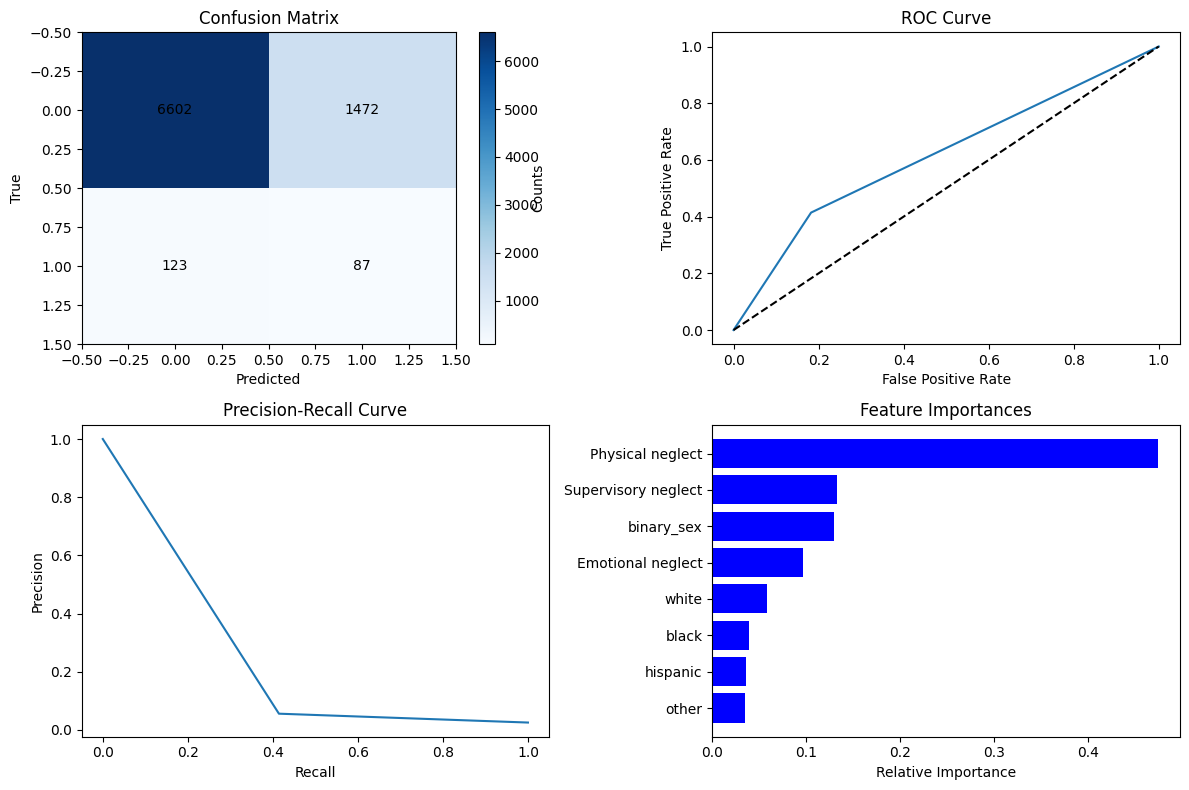

<ipython-input-53-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)
<ipython-input-53-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)
<ipython-input-53-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)
<ipython-input-53-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

,Metric,Score
0,Accuracy,0.807483
1,Precision,0.954865
2,Recall,0.807483
3,F1,0.871843
4,Auc,0.564979


In [ ]:
# Run single model
scores_tb, pipe_tb, model_tb = run_single_model(X_neg, y_tb, strat_k_fold, scoring)

plot_evaluation(pipe_tb, X_neg, y_tb)

generate_metrics_table(scores_tb)

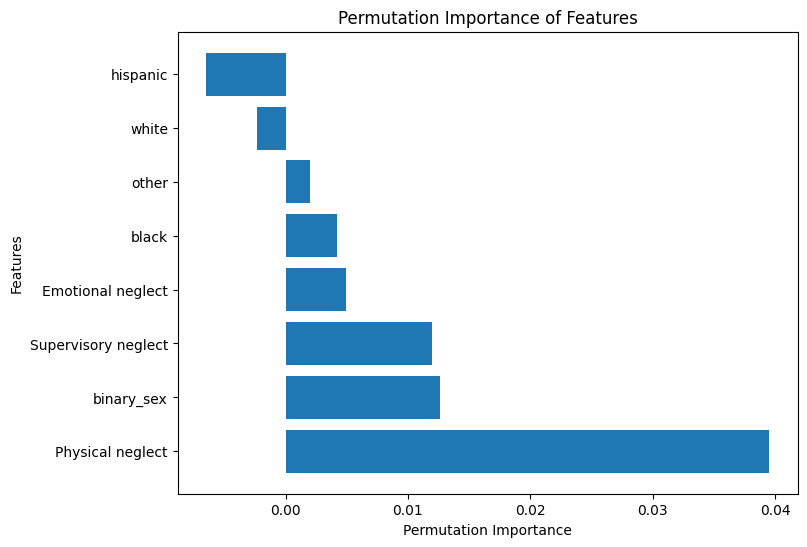

In [ ]:
calculate_permutation_importance(pipe_tb, X_neg, y_tb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

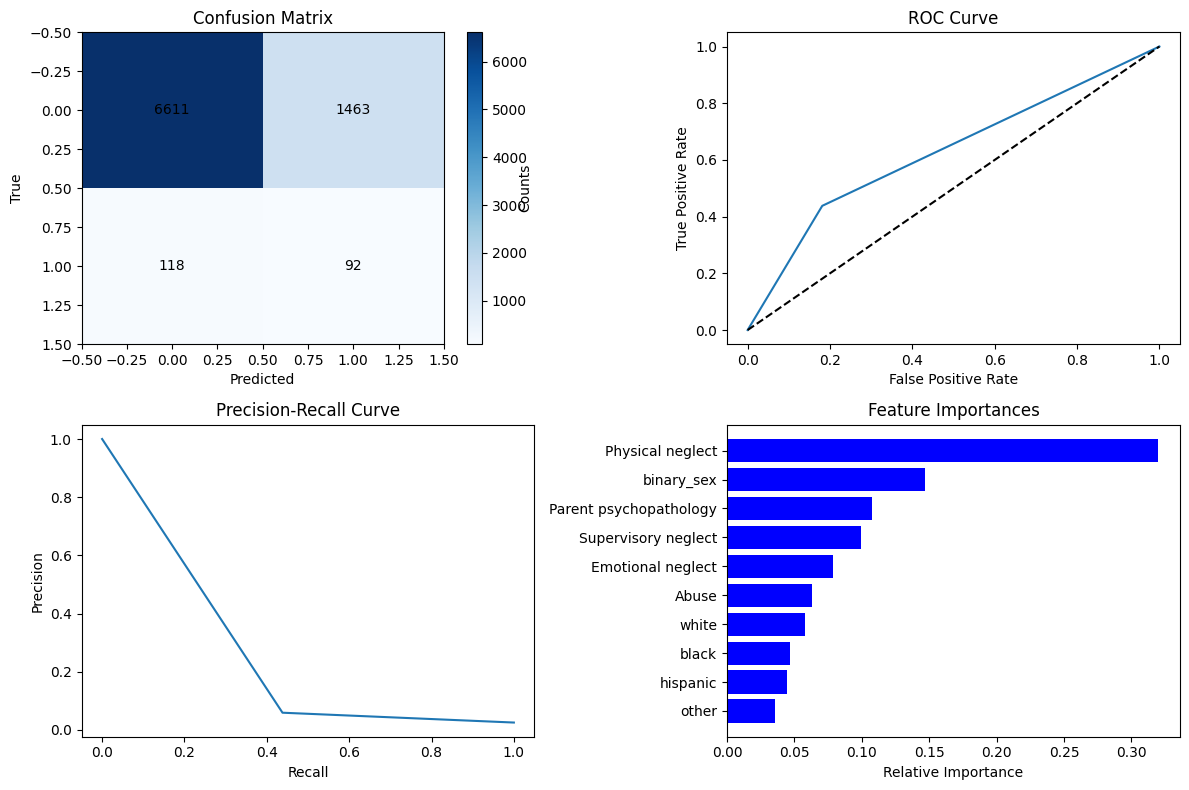

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.805069
1,Precision,0.954789
2,Recall,0.805069
3,F1,0.870365
4,Auc,0.563740


In [ ]:
# Run single model
scores_tb, pipe_tb, model_tb = run_single_model(X_neg_2, y_tb, strat_k_fold, scoring)

plot_evaluation(pipe_tb, X_neg_2, y_tb)

generate_metrics_table(scores_tb)

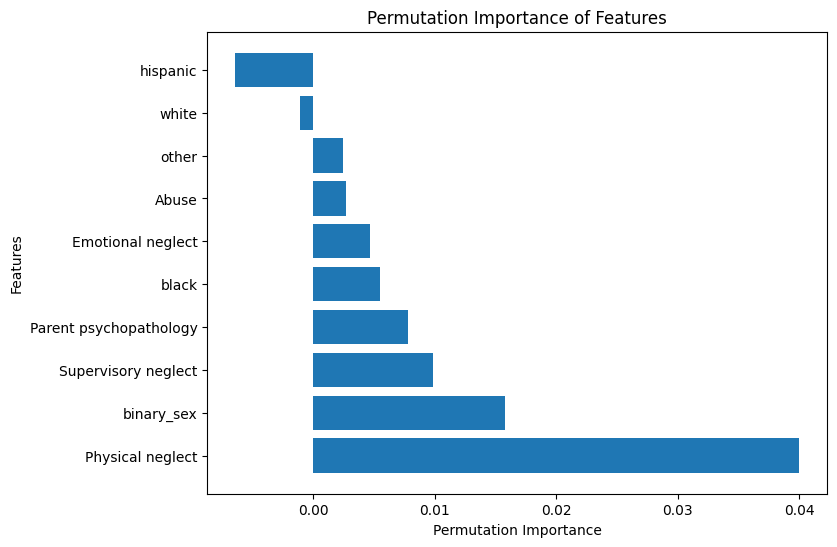

In [ ]:
calculate_permutation_importance(pipe_tb, X_neg_2, y_tb, 'f1')

Internalizing

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

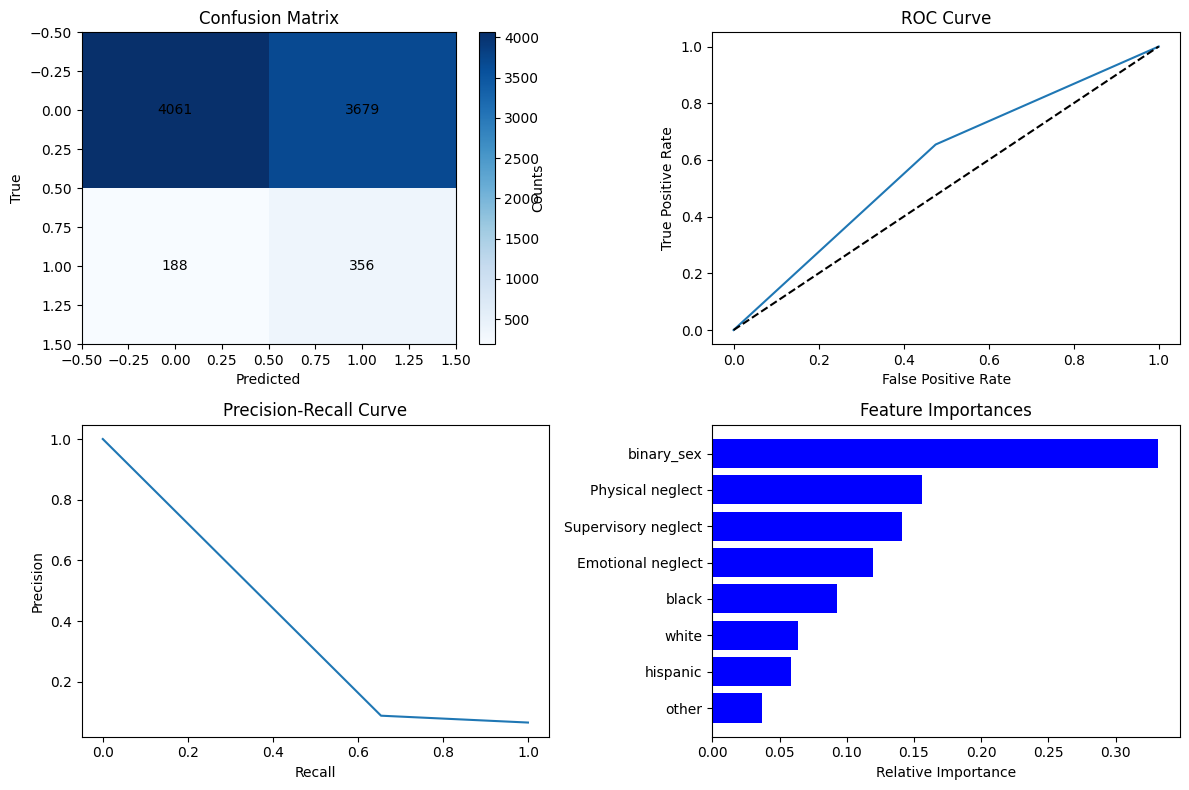

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.527459
1,Precision,0.897730
2,Recall,0.527459
3,F1,0.638125
4,Auc,0.585055


In [ ]:
# Run single model
scores_ib, pipe_ib, model_ib = run_single_model(X_neg, y_ib, strat_k_fold, scoring)

plot_evaluation(pipe_ib, X_neg, y_ib)

generate_metrics_table(scores_ib)

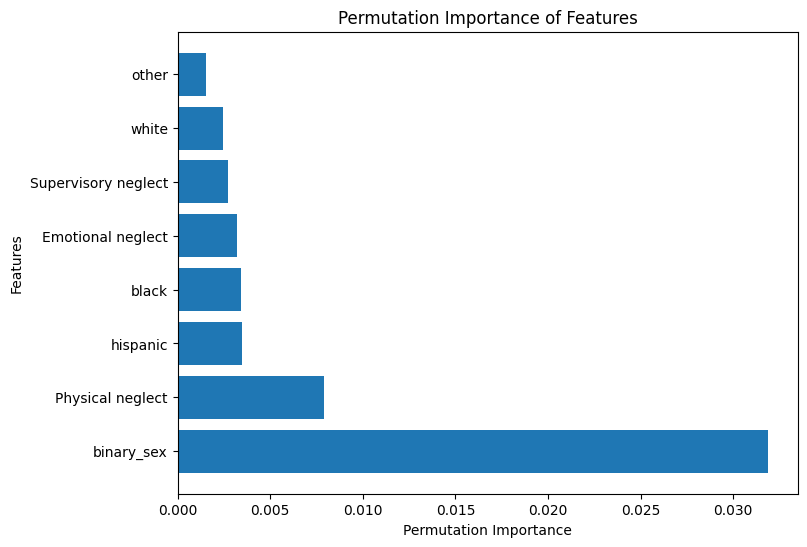

In [ ]:
calculate_permutation_importance(pipe_ib, X_neg, y_ib, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

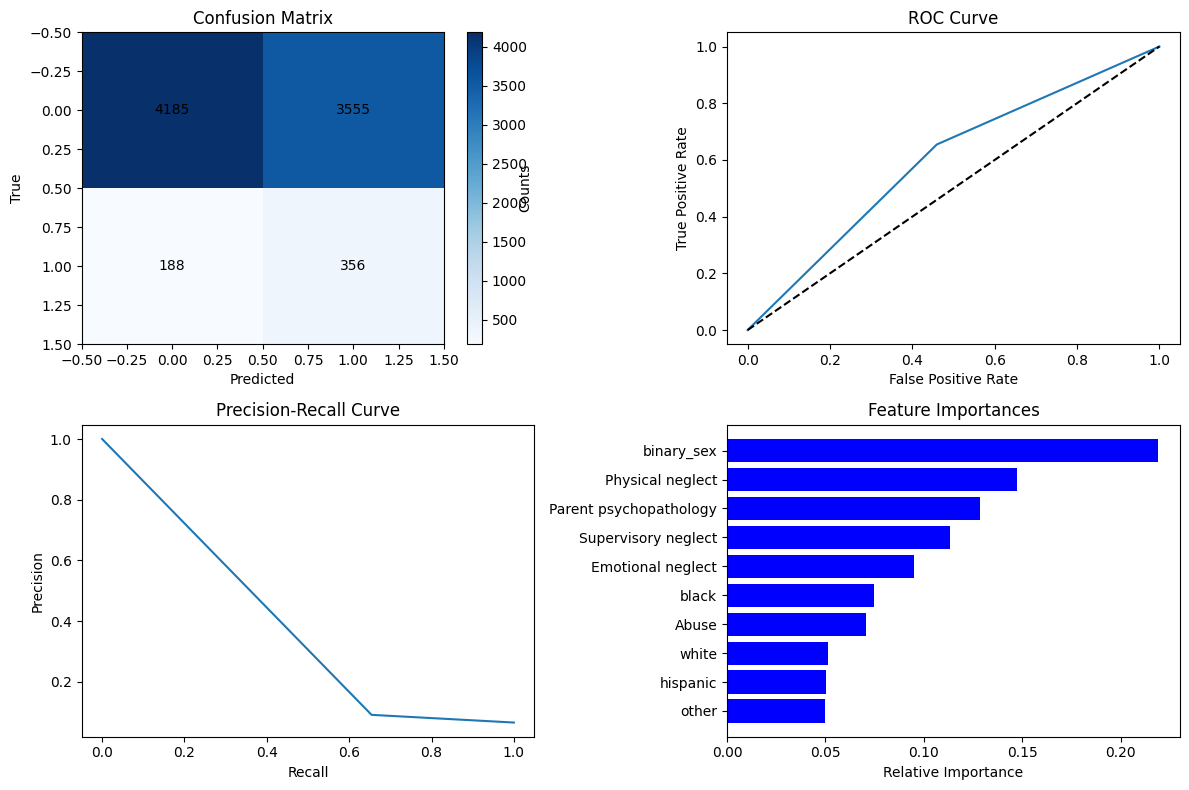

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.537719
1,Precision,0.896577
2,Recall,0.537719
3,F1,0.647326
4,Auc,0.582018


In [ ]:
# Run single model
scores_ib, pipe_ib, model_ib = run_single_model(X_neg_2, y_ib, strat_k_fold, scoring)

plot_evaluation(pipe_ib, X_neg_2, y_ib)

generate_metrics_table(scores_ib)

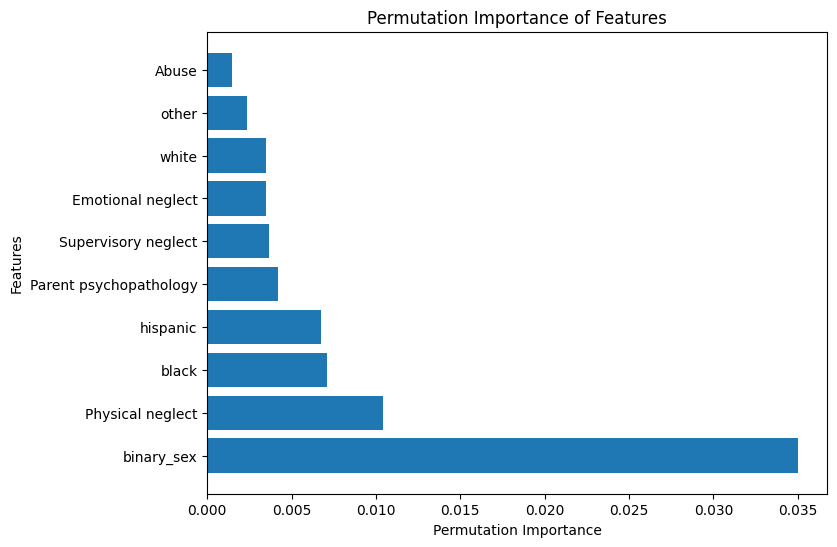

In [ ]:
calculate_permutation_importance(pipe_ib, X_neg_2, y_ib, 'f1')

Externalizing

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

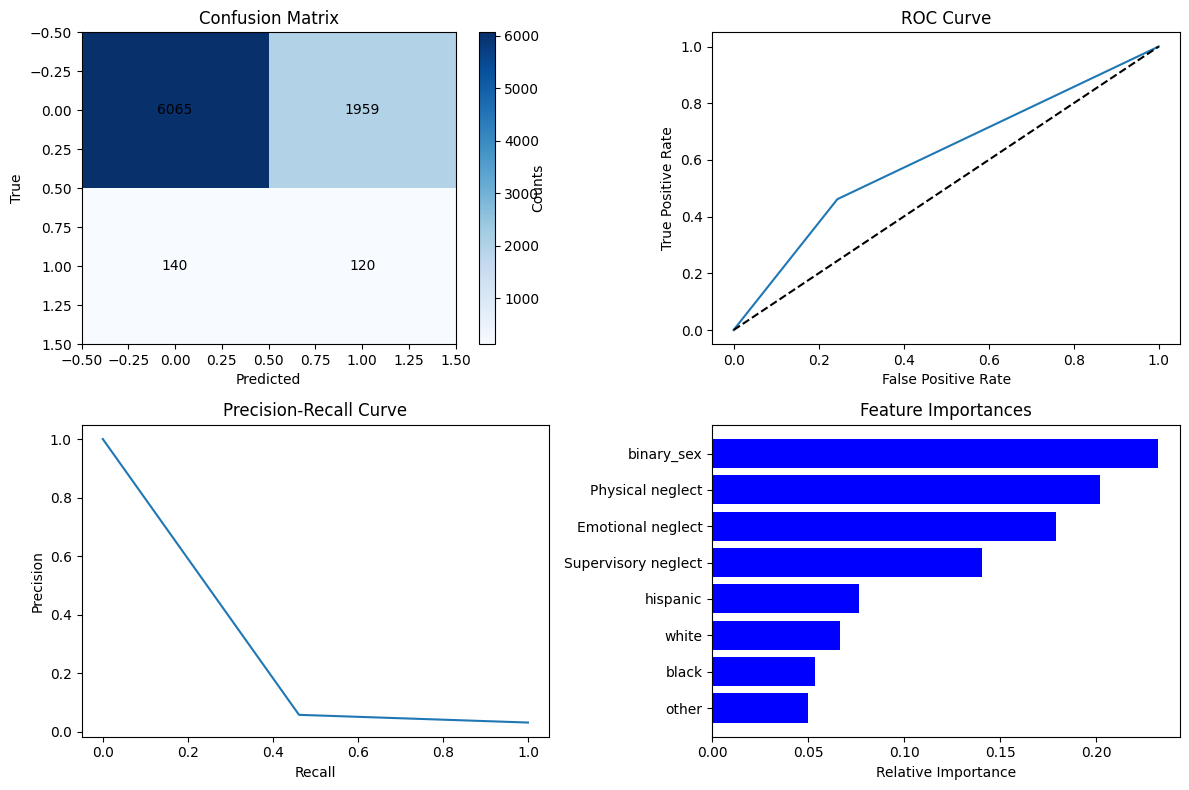

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.741098
1,Precision,0.943512
2,Recall,0.741098
3,F1,0.825194
4,Auc,0.550024


In [ ]:
# Run single model
scores_eb, pipe_eb, model_eb = run_single_model(X_neg, y_eb, strat_k_fold, scoring)

plot_evaluation(pipe_eb, X_neg, y_eb)

generate_metrics_table(scores_eb)

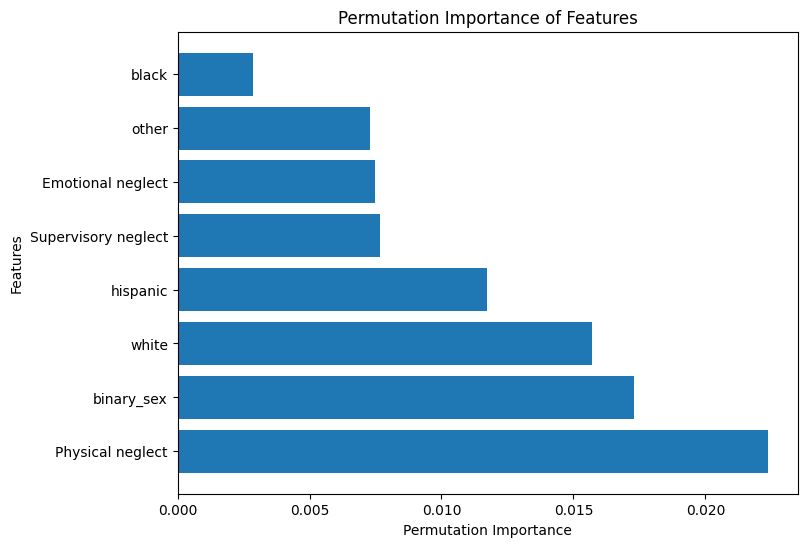

In [ ]:
calculate_permutation_importance(pipe_eb, X_neg, y_eb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

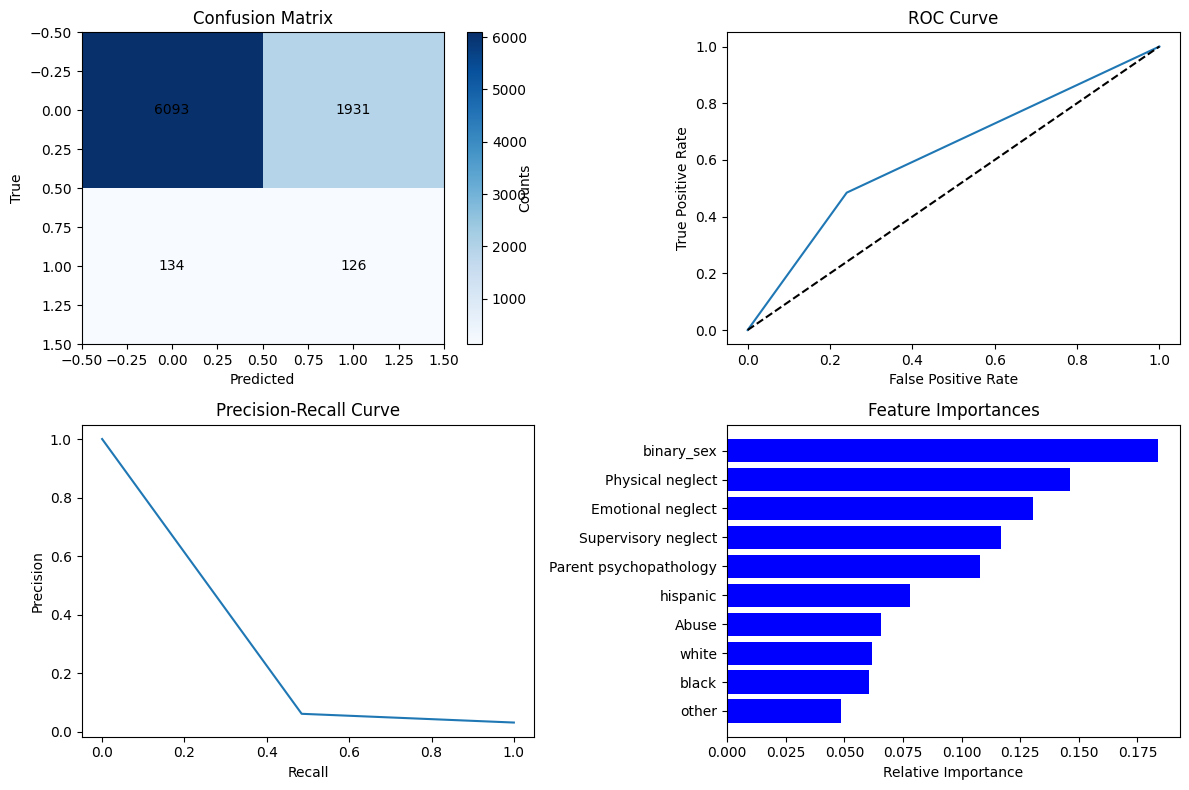

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.744116
1,Precision,0.944439
2,Recall,0.744116
3,F1,0.827197
4,Auc,0.560885


In [ ]:
# Run single model
scores_eb, pipe_eb, model_eb = run_single_model(X_neg_2, y_eb, strat_k_fold, scoring)

plot_evaluation(pipe_eb, X_neg_2, y_eb)

generate_metrics_table(scores_eb)

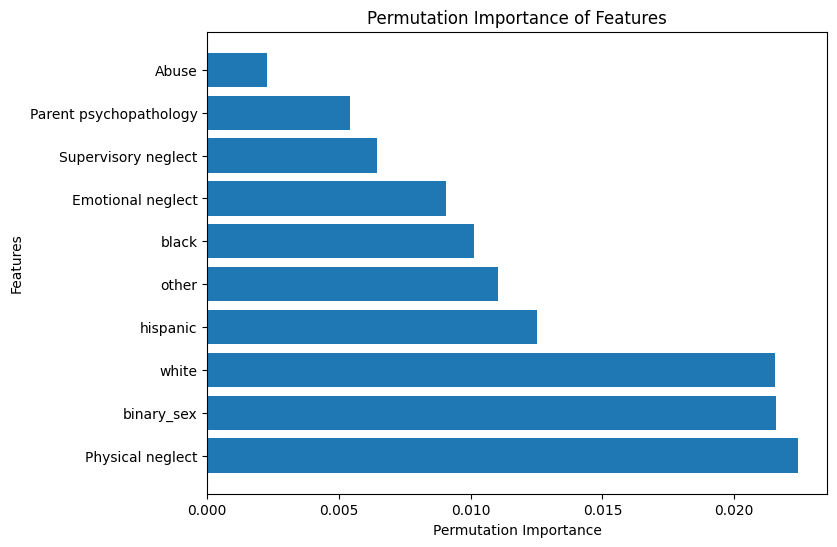

In [ ]:
calculate_permutation_importance(pipe_eb, X_neg_2, y_eb, 'f1')

### STBs

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

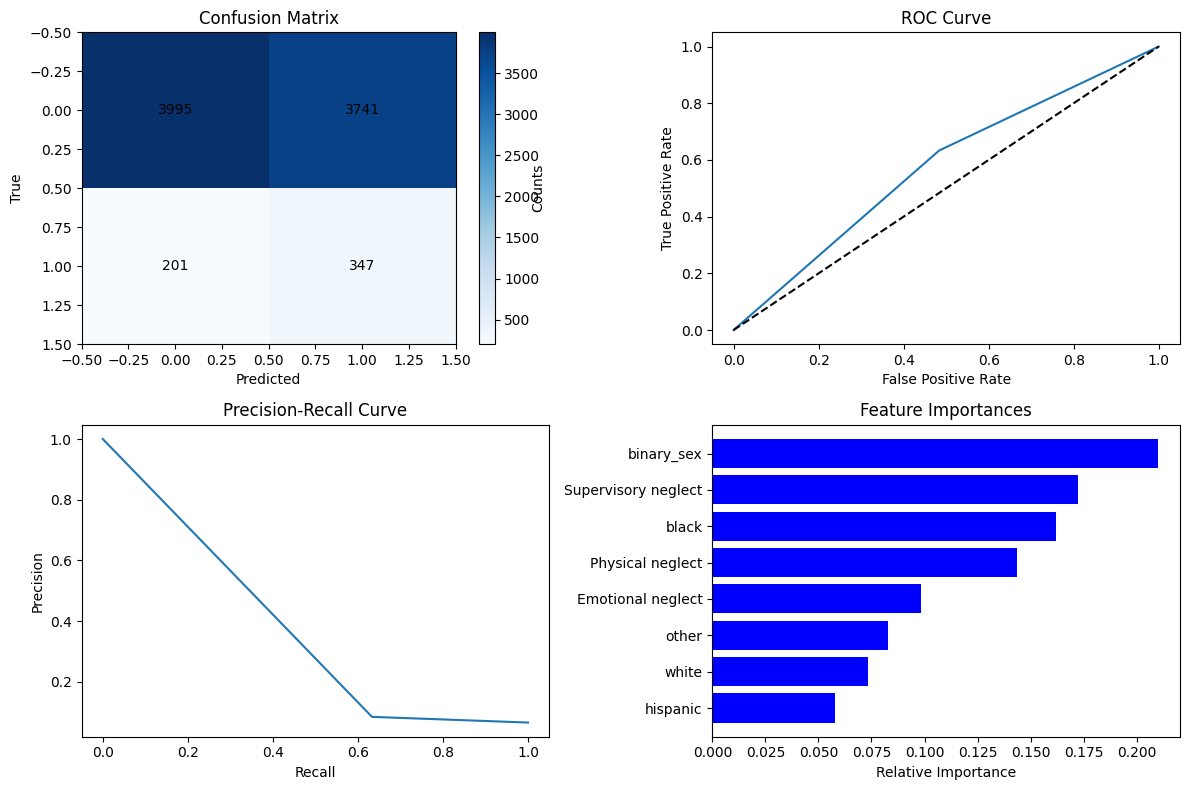

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.506940
1,Precision,0.888618
2,Recall,0.506940
3,F1,0.620327
4,Auc,0.550162


In [ ]:
# Run single model
scores_stb, pipe_stb, model_stb = run_single_model(X_neg, y_stb, strat_k_fold, scoring)

plot_evaluation(pipe_stb, X_neg, y_stb)

generate_metrics_table(scores_stb)

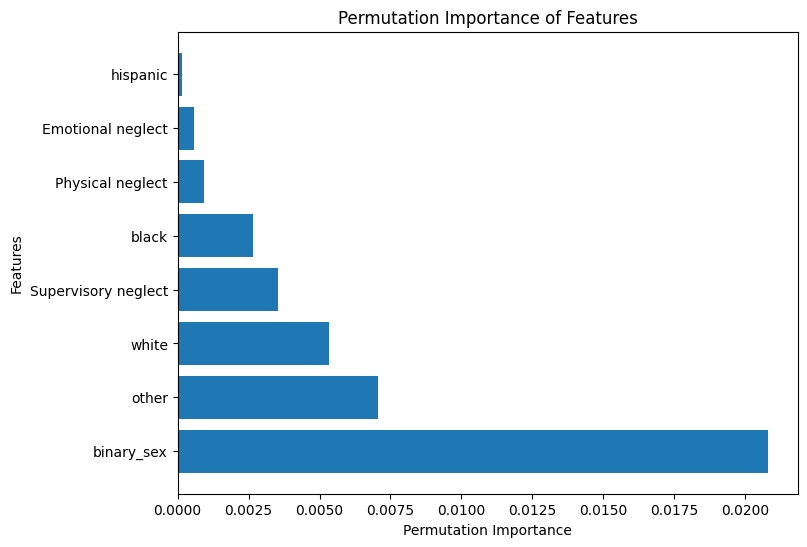

In [ ]:
calculate_permutation_importance(pipe_stb, X_neg, y_stb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

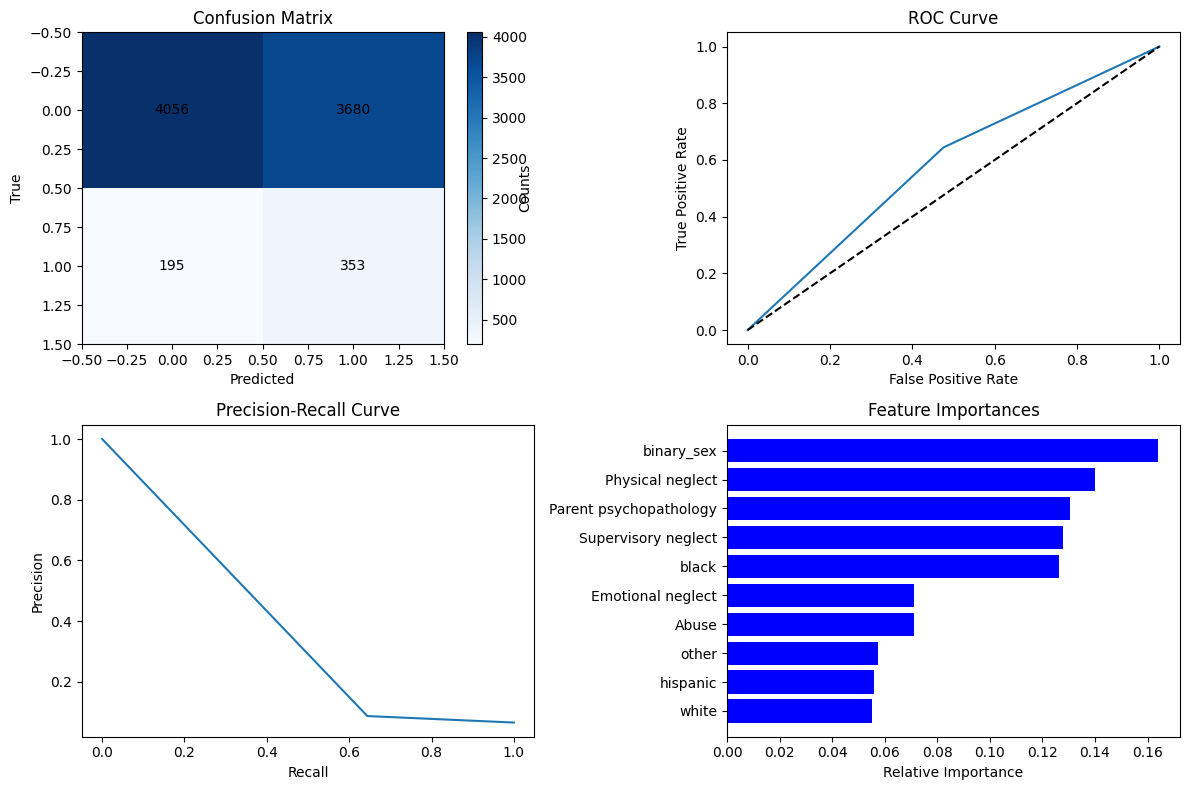

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.516596
1,Precision,0.889683
2,Recall,0.516596
3,F1,0.628927
4,Auc,0.555333


In [ ]:
# Run single model
scores_stb, pipe_stb, model_stb = run_single_model(X_neg_2, y_stb, strat_k_fold, scoring)

plot_evaluation(pipe_stb, X_neg_2, y_stb)

generate_metrics_table(scores_stb)

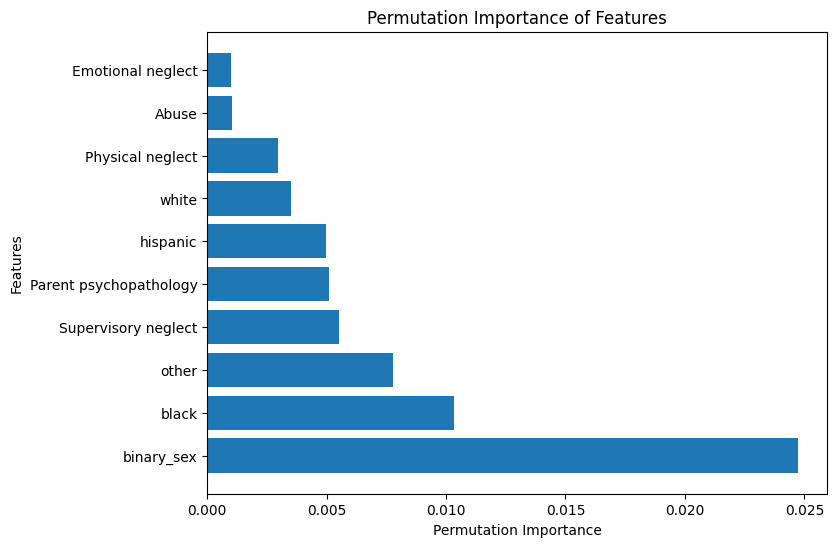

In [ ]:
calculate_permutation_importance(pipe_stb, X_neg_2, y_stb, 'f1')

## Secondary prediction

These models include total problems as a predictor

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

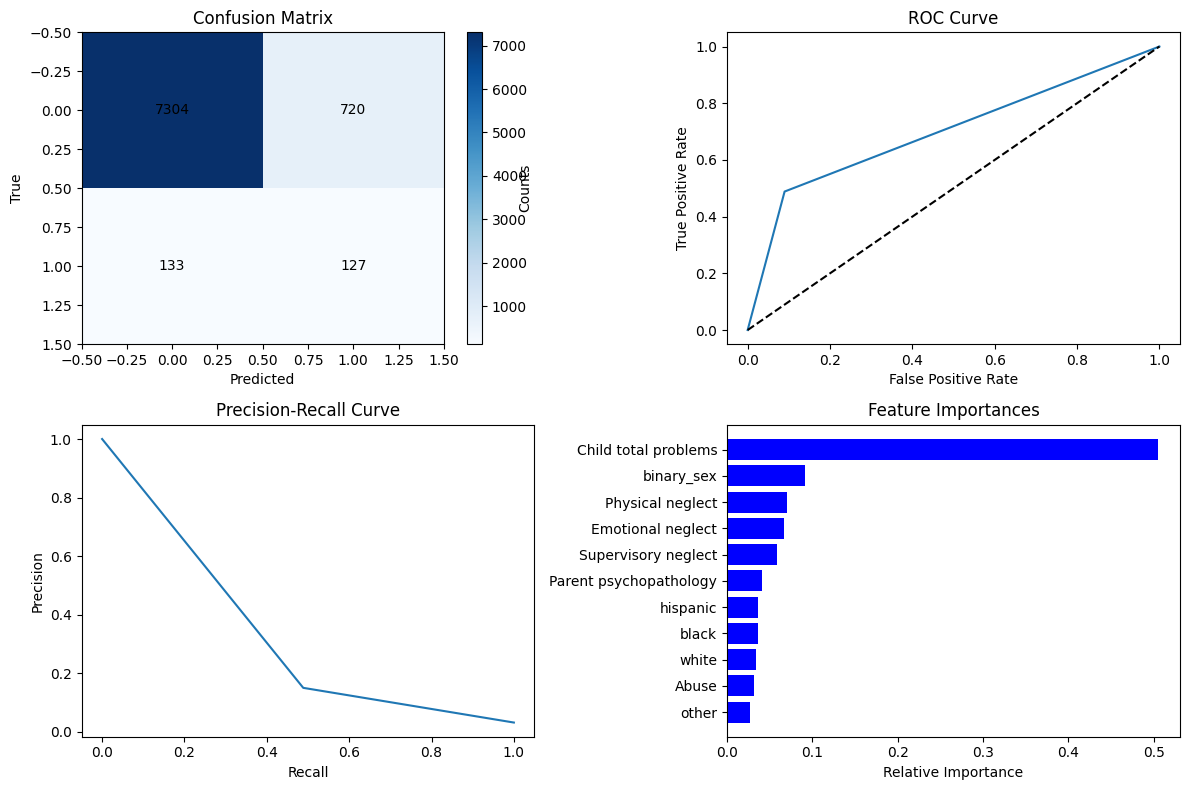

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.901629
1,Precision,0.953726
2,Recall,0.901629
3,F1,0.924473
4,Auc,0.670105


In [ ]:
# Run single model
scores_tbeb, pipe_tbeb, model_tbeb = run_single_model(X_neg_3, y_eb, strat_k_fold, scoring)

plot_evaluation(pipe_tbeb, X_neg_3, y_eb)

generate_metrics_table(scores_tbeb)

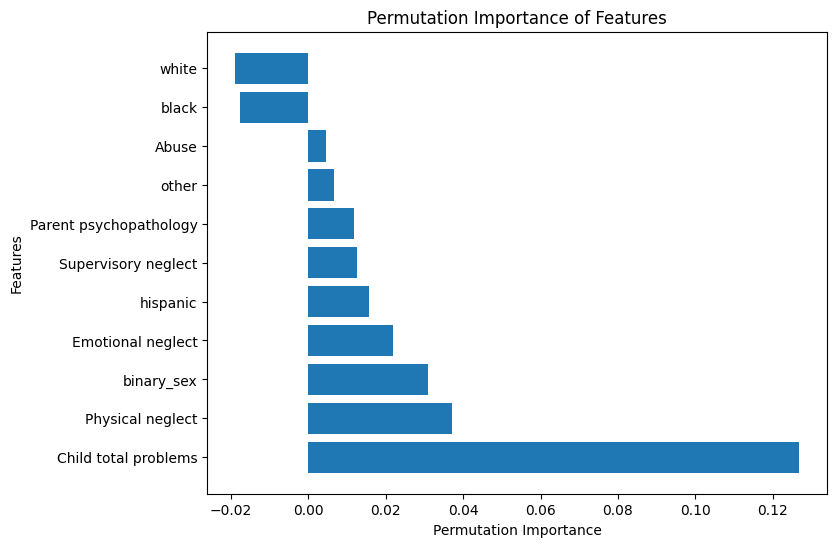

In [ ]:
calculate_permutation_importance(pipe_tbeb, X_neg_3, y_eb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

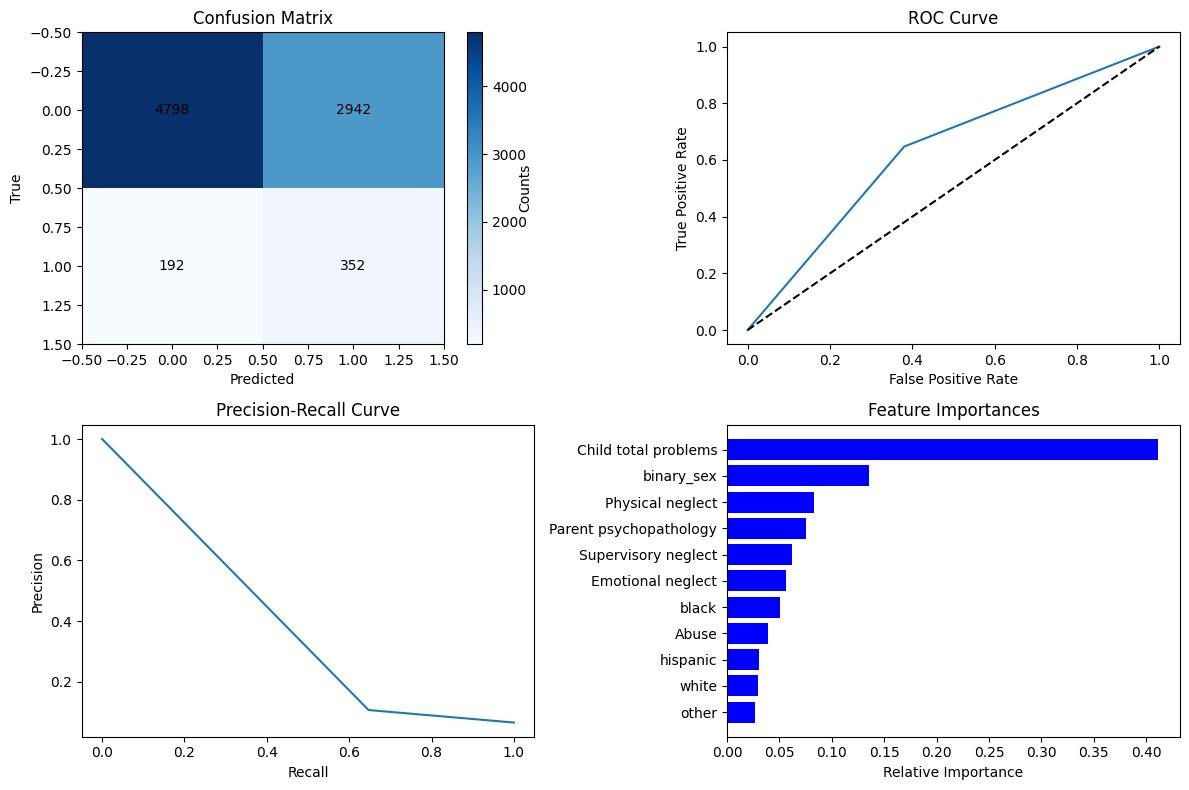

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.606518
1,Precision,0.903553
2,Recall,0.606518
3,F1,0.704328
4,Auc,0.623104


In [ ]:
# Run single model
scores_tbib, pipe_tbib, model_tbib = run_single_model(X_neg_3, y_ib, strat_k_fold, scoring)

plot_evaluation(pipe_tbib, X_neg_3, y_ib)

generate_metrics_table(scores_tbib)

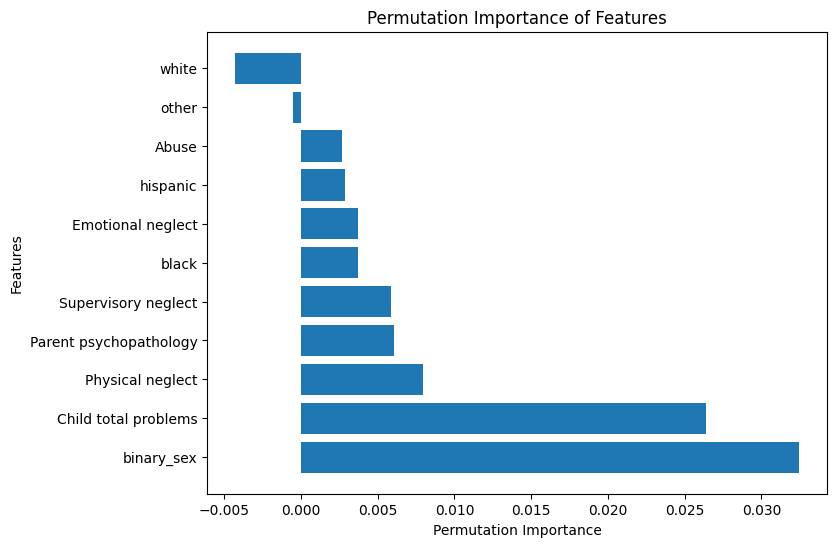

In [ ]:
calculate_permutation_importance(pipe_tbib, X_neg_3, y_ib, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

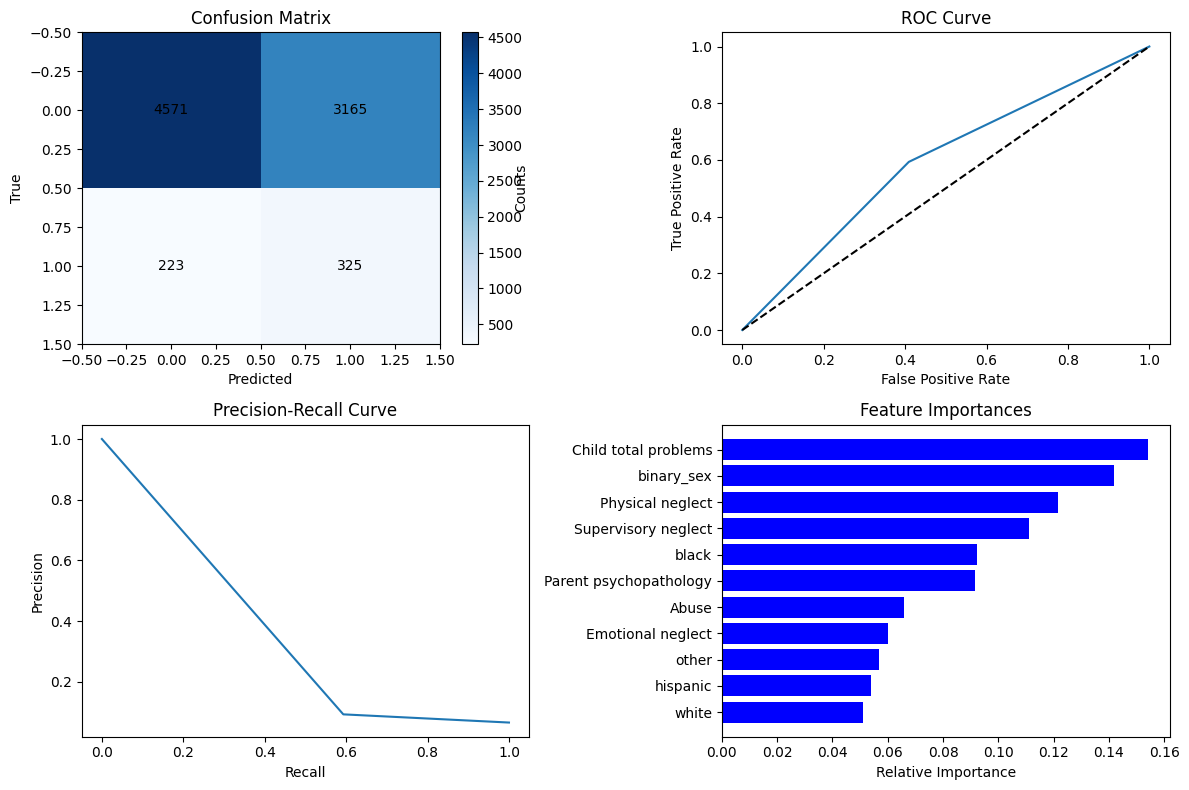

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.576946
1,Precision,0.888913
2,Recall,0.576946
3,F1,0.680869
4,Auc,0.558098


In [ ]:
# Run single model
scores_tbstb, pipe_tbstb, model_tbstb = run_single_model(X_neg_3, y_stb, strat_k_fold, scoring)

plot_evaluation(pipe_tbstb, X_neg_3, y_stb)

generate_metrics_table(scores_tbstb)

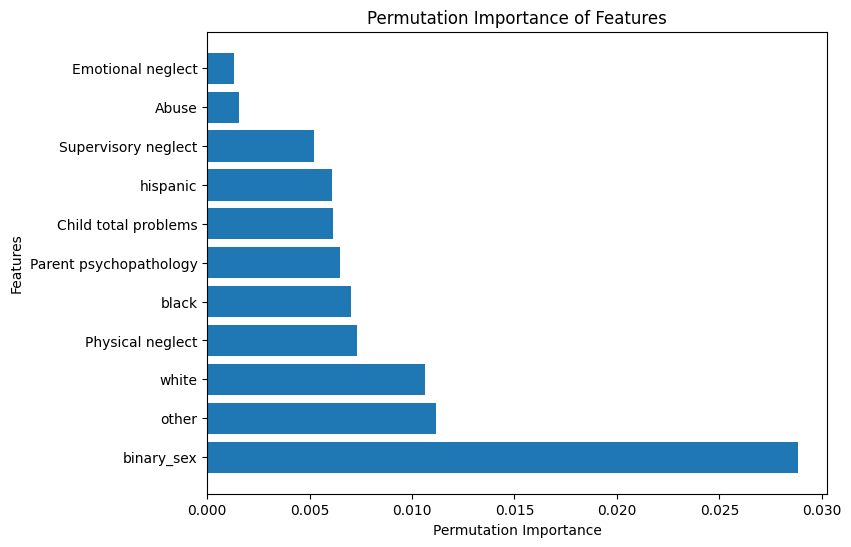

In [ ]:
calculate_permutation_importance(pipe_tbstb, X_neg_3, y_stb, 'f1')

# Bootstrap confidence intervals

## Total problems

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

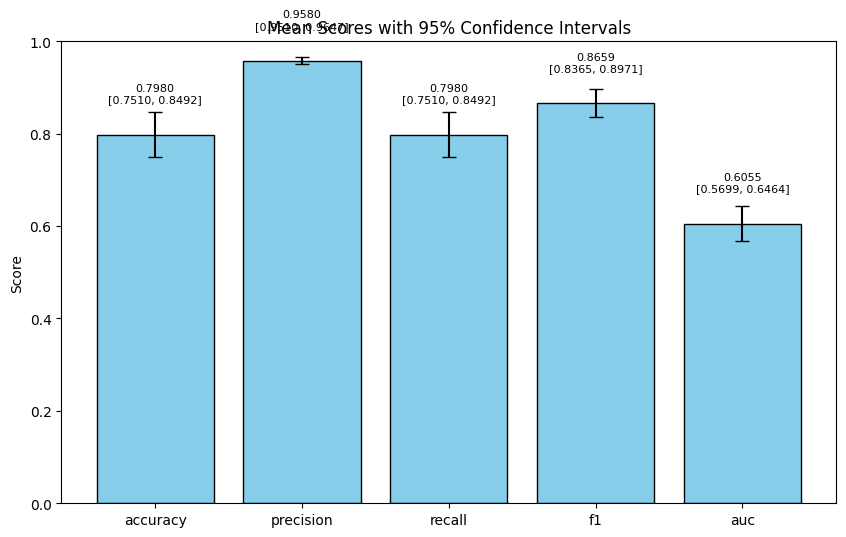

CPU times: user 55.9 s, sys: 462 ms, total: 56.3 s
Wall time: 56 s


,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.7980,"[0.751, 0.8492]"
1,precision,0.9580,"[0.951, 0.9647]"
2,recall,0.7980,"[0.751, 0.8492]"
3,f1,0.8659,"[0.8365, 0.8971]"
4,auc,0.6055,"[0.5699, 0.6464]"


In [55]:
%%time

ci_neg_tb = bootstrap_cross_validation(X_neg, y_tb, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg_tb)

create_results_table(ci_neg_tb)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

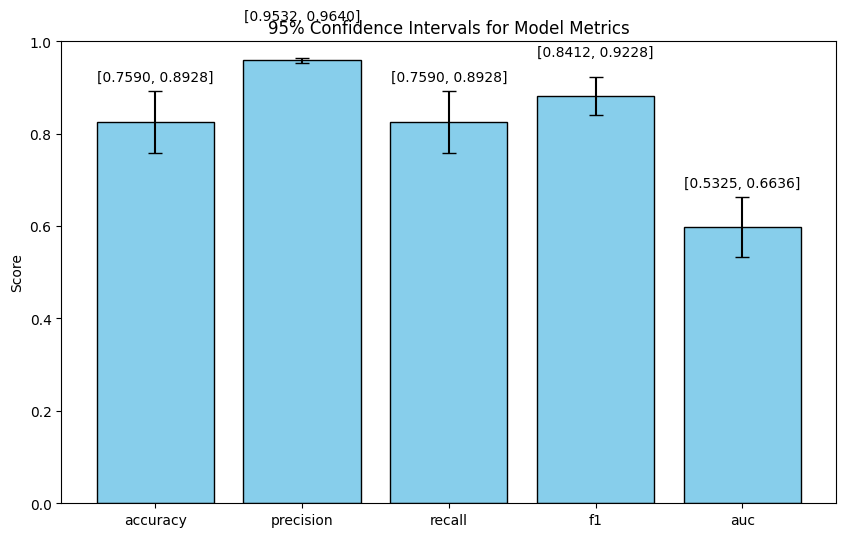

In [ ]:
# X_neg_2

ci_neg2_tb = bootstrap_cross_validation(X_neg_2, y_tb, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg2_tb)

create_results_table(ci_neg2_tb)

## Interalizing

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

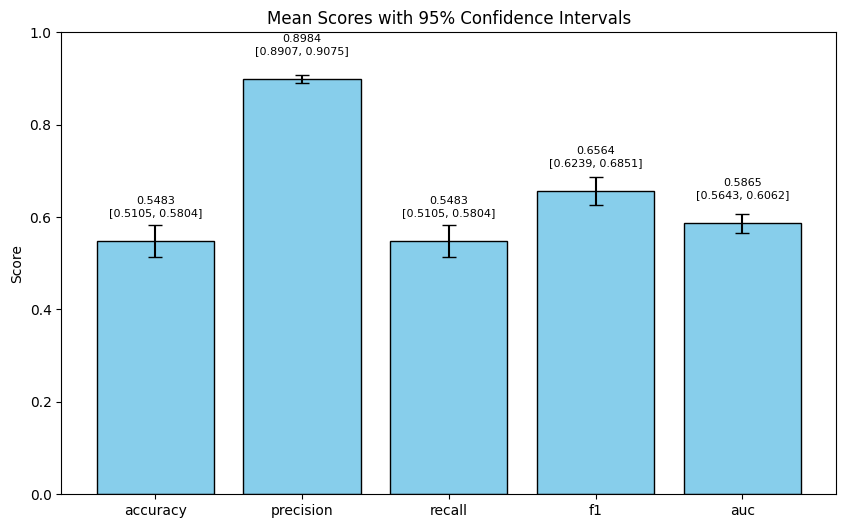

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.5483,"[0.5105, 0.5804]"
1,precision,0.8984,"[0.8907, 0.9075]"
2,recall,0.5483,"[0.5105, 0.5804]"
3,f1,0.6564,"[0.6239, 0.6851]"
4,auc,0.5865,"[0.5643, 0.6062]"


In [56]:
ci_neg_ib = bootstrap_cross_validation(X_neg, y_ib, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg_ib)

create_results_table(ci_neg_ib)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

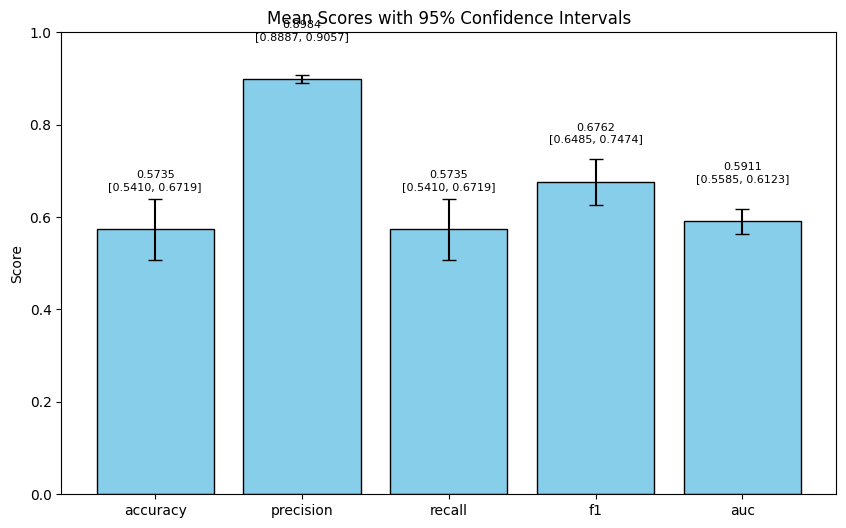

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.5735,"[0.541, 0.6719]"
1,precision,0.8984,"[0.8887, 0.9057]"
2,recall,0.5735,"[0.541, 0.6719]"
3,f1,0.6762,"[0.6485, 0.7474]"
4,auc,0.5911,"[0.5585, 0.6123]"


In [57]:
# X_neg_2
ci_neg2_ib = bootstrap_cross_validation(X_neg_2, y_ib, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg2_ib)

create_results_table(ci_neg2_ib)

## Externalizing

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

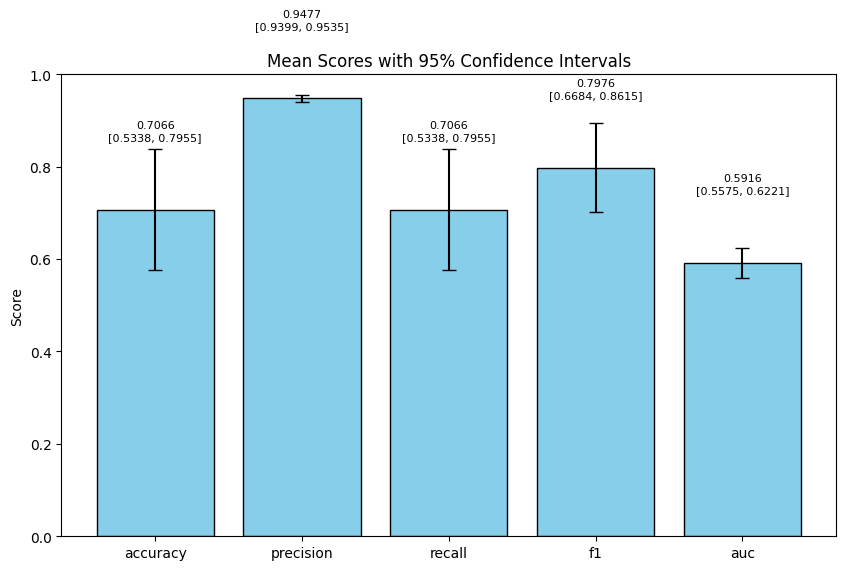

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.7066,"[0.5338, 0.7955]"
1,precision,0.9477,"[0.9399, 0.9535]"
2,recall,0.7066,"[0.5338, 0.7955]"
3,f1,0.7976,"[0.6684, 0.8615]"
4,auc,0.5916,"[0.5575, 0.6221]"


In [58]:
ci_neg_eb = bootstrap_cross_validation(X_neg, y_eb, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg_eb)

create_results_table(ci_neg_eb)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

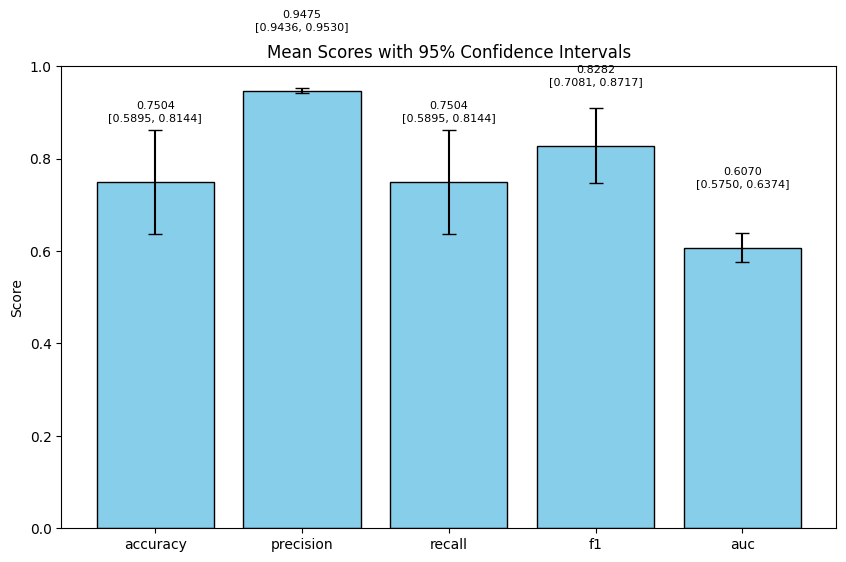

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.7504,"[0.5895, 0.8144]"
1,precision,0.9475,"[0.9436, 0.953]"
2,recall,0.7504,"[0.5895, 0.8144]"
3,f1,0.8282,"[0.7081, 0.8717]"
4,auc,0.6070,"[0.575, 0.6374]"


In [59]:
# X_neg_2
ci_neg2_eb = bootstrap_cross_validation(X_neg_2, y_eb, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg2_eb)

create_results_table(ci_neg2_eb)

## STBs

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

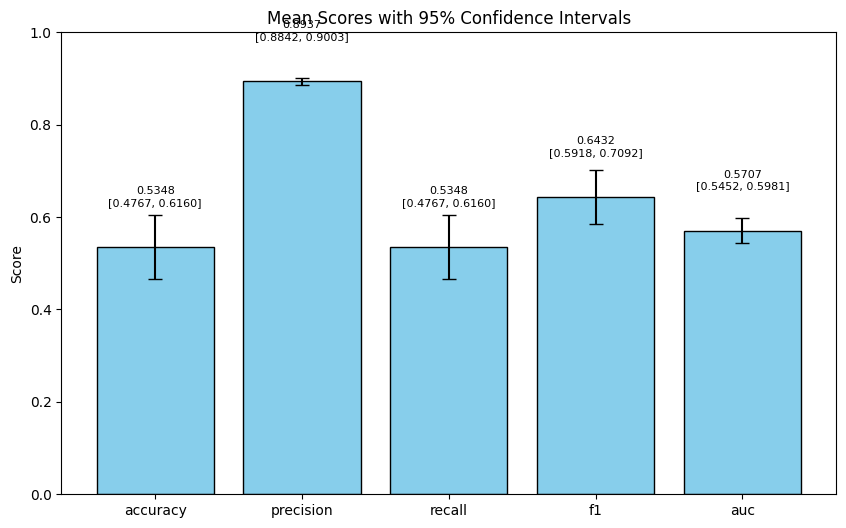

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.5348,"[0.4767, 0.616]"
1,precision,0.8937,"[0.8842, 0.9003]"
2,recall,0.5348,"[0.4767, 0.616]"
3,f1,0.6432,"[0.5918, 0.7092]"
4,auc,0.5707,"[0.5452, 0.5981]"


In [62]:
ci_neg_stb = bootstrap_cross_validation(X_neg, y_stb, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg_stb)

create_results_table(ci_neg_stb)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

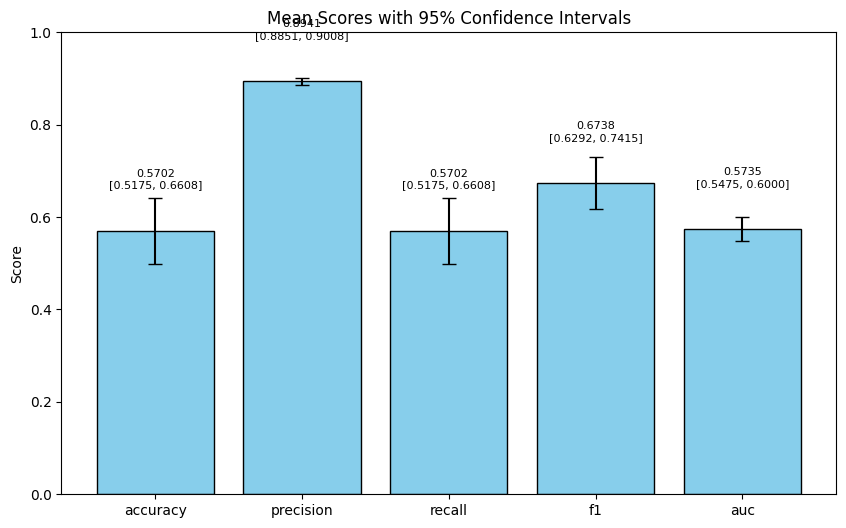

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.5702,"[0.5175, 0.6608]"
1,precision,0.8941,"[0.8851, 0.9008]"
2,recall,0.5702,"[0.5175, 0.6608]"
3,f1,0.6738,"[0.6292, 0.7415]"
4,auc,0.5735,"[0.5475, 0.6]"


In [61]:
# X_neg_2
ci_neg2_stb = bootstrap_cross_validation(X_neg_2, y_stb, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_neg2_stb)

create_results_table(ci_neg2_stb)